# Problem 10.1

**Problem 10.1. Capacity and dispatch optimization in a network.**

**We build on the models described in Problems 8 and 9, however we add Denmark as a second node. Optimize the capacity and dispatch of solar PV, onshore wind, and Open Cycle Gas Turbine (OCGT) generators to supply the inelastic electricity demand throughout one year. 
To do this, take the time series for the wind and solar capacity factors for Portugal *and Denmark* in 2015 obtained from https://zenodo.org/record/3253876#.XSiVOEdS8l0
and https://zenodo.org/record/2613651#.X0kbhDVS-uV (select the file ‘pvoptimal.csv’) and  the electricity demand from https://github.com/martavp/integrated-energy-grids/tree/main/integrated-energy-grids/Problems/data.
Assume that methane gas emits 0.198 tCO2 per MWh of thermal energy contained in the gas. We assume the distance between the two nodes is 2477 km, the distance between Copenhagen and Lisbon.**






**For all of the following subproblems, always calculate the following values:** 
 - **Total system costs (in bn EUR)**
 - **Average electricity price (in EUR/MWh); number/share of hours with a price below 2 EUR/MWh**
 - **Congestion rent**
 - **Utilisation of transmission lines (in % of cap.)**
 - **Total generation per technology (in TWh)**
 - **Total CO2 emissions (in MtCO2)**


**a) Set up a network with two nodes and connect them with an overhead AC line (however, keep the capacity at 0 GW, and it cannot be extended).**

**b) Now assume the AC line connecting Portugal and Denmark has a capacity of 1 GW.**

**c) Now assume the AC line connecting Portugal and Denmark has a capacity of 10 GW.**

**d) Optimise the AC line capacity endogenously (assume it starts at 0 GW capacity).**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa

## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [2]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [3]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [4]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [5]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the marginal generation costs (€/MWh):

In [6]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [7]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [8]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

We can now read the capital and marginal cost of onshore wind, solar and OCGT

In [9]:
costs.at["onwind", "capital_cost"] #EUR/MW/a

np.float64(101644.12332388277)

In [10]:
costs.at["solar", "capital_cost"] #EUR/MW/a

np.float64(51346.82981964593)

In [11]:
costs.at["OCGT", "capital_cost"] #EUR/MW/a

np.float64(47718.67056370105)

In [12]:
costs.at["OCGT", "marginal_cost"] #EUR/MWh

np.float64(64.6839512195122)

## Retrieving time series data

In this example, wind data from [https://zenodo.org/record/3253876#.XSiVOEdS8l0](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and solar PV data from [https://zenodo.org/record/2613651#.X0kbhDVS-uV](https://zenodo.org/record/3253876#.XSiVOEdS8l0) is used. The data is downloaded in csv format and saved in the 'data' folder.
The Pandas package is used as a convenient way of managing the datasets.

For convenience, the column including date information is converted into Datetime and set as index

In [13]:
data_solar = pd.read_csv('data/pv_optimal.csv',sep=';')
data_solar.index = pd.DatetimeIndex(data_solar['utc_time'])

data_wind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';')
data_wind.index = pd.DatetimeIndex(data_wind['utc_time'])

data_el = pd.read_csv('data/electricity_demand.csv',sep=';')
data_el.index = pd.DatetimeIndex(data_el['utc_time'])

The data format can now be analyzed using the .head() function to show the first lines of the data set

In [14]:
data_solar.head()

,utc_time,AUT,BEL,BGR,BIH,CHE,CYP,CZE,DEU,DNK,...,MLT,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE
utc_time,,,,,,,,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,1979-01-01T00:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 01:00:00+00:00,1979-01-01T01:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 02:00:00+00:00,1979-01-01T02:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 03:00:00+00:00,1979-01-01T03:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 04:00:00+00:00,1979-01-01T04:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will use timeseries for Portugal and Denmark in this excercise

In [15]:
countries = ['PRT', 'DNK']
coordinates = {'PRT': (38.74, -9.15), 'DNK': (55.67, 12.57)}

# a. Capacity and dispatch optimisation in a network, F = 0 GW

For building the model, we start again by initialising an empty network, adding the snapshots, and the electricity bus.

In [16]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          v_nom = 400,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )


/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dt

In [17]:
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "battery storage",
]

n.madd(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Index(['onwind', 'solar', 'OCGT', 'battery storage'], dtype='object')

In [18]:
# add load to the bus
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")

In [19]:
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

In [20]:
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 0,
    x = 1,
    r = 1,
)

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x17fa3da60>,
 <matplotlib.collections.LineCollection at 0x303fbdb80>)

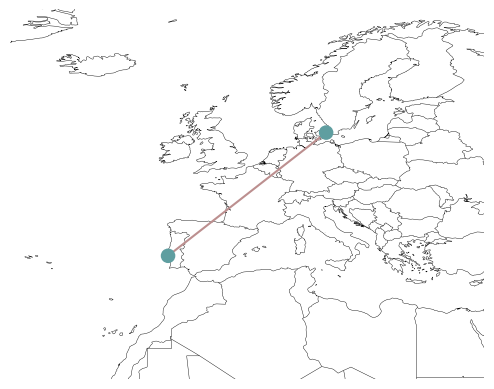

In [21]:
n.plot(bus_sizes=1, margin=1)

In [22]:
n.optimize(solver_name="gurobi")

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2609678


INFO:gurobipy:Set parameter LicenseID to value 2609678


Academic license - for non-commercial use only - expires 2026-01-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 66.47it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-lxws5uo3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-lxws5uo3.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 140166 rows, 61326 columns, 236551 nonzeros


INFO:gurobipy:obj: 140166 rows, 61326 columns, 236551 nonzeros


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61326 columns and 236551 nonzeros


INFO:gurobipy:Optimize a model with 140166 rows, 61326 columns and 236551 nonzeros


Model fingerprint: 0xc83c5ab6


INFO:gurobipy:Model fingerprint: 0xc83c5ab6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 9e+03]


INFO:gurobipy:  RHS range        [2e+03, 9e+03]


Presolve removed 87556 rows and 26230 columns


INFO:gurobipy:Presolve removed 87556 rows and 26230 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 52610 rows, 35096 columns, 114005 nonzeros


INFO:gurobipy:Presolved: 52610 rows, 35096 columns, 114005 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 7.892e+04


INFO:gurobipy: AA' NZ     : 7.892e+04


 Factor NZ  : 2.544e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 2.544e+05 (roughly 40 MB of memory)


 Factor Ops : 1.325e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.325e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.46588478e+10 -3.70662960e+11  8.69e+04 2.20e-13  1.53e+08     0s


INFO:gurobipy:   0   5.46588478e+10 -3.70662960e+11  8.69e+04 2.20e-13  1.53e+08     0s


   1   1.00173309e+11 -4.81775490e+11  1.07e+04 6.38e+02  2.77e+07     0s


INFO:gurobipy:   1   1.00173309e+11 -4.81775490e+11  1.07e+04 6.38e+02  2.77e+07     0s


   2   9.16553033e+10 -1.97469164e+11  7.28e-12 1.21e+00  2.58e+06     0s


INFO:gurobipy:   2   9.16553033e+10 -1.97469164e+11  7.28e-12 1.21e+00  2.58e+06     0s


   3   1.94386009e+10 -1.92838349e+10  7.28e-12 1.46e-11  3.41e+05     0s


INFO:gurobipy:   3   1.94386009e+10 -1.92838349e+10  7.28e-12 1.46e-11  3.41e+05     0s


   4   9.84672045e+09 -5.33198343e+09  7.28e-12 1.19e-09  1.33e+05     0s


INFO:gurobipy:   4   9.84672045e+09 -5.33198343e+09  7.28e-12 1.19e-09  1.33e+05     0s


   5   8.59508822e+09 -7.62629932e+08  7.28e-12 8.73e-10  8.22e+04     0s


INFO:gurobipy:   5   8.59508822e+09 -7.62629932e+08  7.28e-12 8.73e-10  8.22e+04     0s


   6   7.64223940e+09  1.51736846e+09  2.55e-11 1.57e-09  5.38e+04     0s


INFO:gurobipy:   6   7.64223940e+09  1.51736846e+09  2.55e-11 1.57e-09  5.38e+04     0s


   7   6.54100664e+09  2.94577551e+09  9.46e-11 7.28e-10  3.16e+04     0s


INFO:gurobipy:   7   6.54100664e+09  2.94577551e+09  9.46e-11 7.28e-10  3.16e+04     0s


   8   5.93920735e+09  3.69895466e+09  1.46e-11 2.62e-10  1.97e+04     0s


INFO:gurobipy:   8   5.93920735e+09  3.69895466e+09  1.46e-11 2.62e-10  1.97e+04     0s


   9   5.66701376e+09  4.57644617e+09  4.00e-11 1.46e-10  9.57e+03     0s


INFO:gurobipy:   9   5.66701376e+09  4.57644617e+09  4.00e-11 1.46e-10  9.57e+03     0s


  10   5.50945025e+09  4.85752354e+09  1.78e-10 9.31e-10  5.72e+03     0s


INFO:gurobipy:  10   5.50945025e+09  4.85752354e+09  1.78e-10 9.31e-10  5.72e+03     0s


  11   5.40620944e+09  4.98268432e+09  4.80e-10 6.11e-10  3.72e+03     0s


INFO:gurobipy:  11   5.40620944e+09  4.98268432e+09  4.80e-10 6.11e-10  3.72e+03     0s


  12   5.35580066e+09  5.00777396e+09  1.28e-09 1.75e-10  3.05e+03     0s


INFO:gurobipy:  12   5.35580066e+09  5.00777396e+09  1.28e-09 1.75e-10  3.05e+03     0s


  13   5.33709085e+09  5.03544563e+09  1.45e-09 8.73e-11  2.65e+03     0s


INFO:gurobipy:  13   5.33709085e+09  5.03544563e+09  1.45e-09 8.73e-11  2.65e+03     0s


  14   5.30901486e+09  5.06530513e+09  2.66e-10 6.11e-10  2.14e+03     0s


INFO:gurobipy:  14   5.30901486e+09  5.06530513e+09  2.66e-10 6.11e-10  2.14e+03     0s


  15   5.25487020e+09  5.08419974e+09  8.71e-10 8.73e-10  1.50e+03     0s


INFO:gurobipy:  15   5.25487020e+09  5.08419974e+09  8.71e-10 8.73e-10  1.50e+03     0s


  16   5.22365376e+09  5.12498354e+09  6.00e-10 4.66e-10  8.66e+02     0s


INFO:gurobipy:  16   5.22365376e+09  5.12498354e+09  6.00e-10 4.66e-10  8.66e+02     0s


  17   5.21148387e+09  5.12887466e+09  1.33e-09 8.73e-11  7.25e+02     0s


INFO:gurobipy:  17   5.21148387e+09  5.12887466e+09  1.33e-09 8.73e-11  7.25e+02     0s


  18   5.19905794e+09  5.13388242e+09  1.14e-09 4.66e-10  5.72e+02     0s


INFO:gurobipy:  18   5.19905794e+09  5.13388242e+09  1.14e-09 4.66e-10  5.72e+02     0s


  19   5.19204502e+09  5.14006580e+09  8.19e-10 2.62e-10  4.56e+02     0s


INFO:gurobipy:  19   5.19204502e+09  5.14006580e+09  8.19e-10 2.62e-10  4.56e+02     0s


  20   5.18227131e+09  5.14874186e+09  2.21e-09 2.91e-10  2.94e+02     0s


INFO:gurobipy:  20   5.18227131e+09  5.14874186e+09  2.21e-09 2.91e-10  2.94e+02     0s


  21   5.17815390e+09  5.15693791e+09  1.54e-09 5.82e-10  1.86e+02     0s


INFO:gurobipy:  21   5.17815390e+09  5.15693791e+09  1.54e-09 5.82e-10  1.86e+02     0s


  22   5.17620616e+09  5.15824492e+09  1.83e-09 7.57e-10  1.58e+02     0s


INFO:gurobipy:  22   5.17620616e+09  5.15824492e+09  1.83e-09 7.57e-10  1.58e+02     0s


  23   5.17359874e+09  5.16016182e+09  2.46e-09 6.98e-10  1.18e+02     0s


INFO:gurobipy:  23   5.17359874e+09  5.16016182e+09  2.46e-09 6.98e-10  1.18e+02     0s


  24   5.17267149e+09  5.16362224e+09  1.82e-09 2.62e-10  7.94e+01     0s


INFO:gurobipy:  24   5.17267149e+09  5.16362224e+09  1.82e-09 2.62e-10  7.94e+01     0s


  25   5.17193808e+09  5.16432434e+09  4.90e-09 2.33e-10  6.68e+01     0s


INFO:gurobipy:  25   5.17193808e+09  5.16432434e+09  4.90e-09 2.33e-10  6.68e+01     0s


  26   5.17166216e+09  5.16476678e+09  7.45e-09 2.33e-10  6.05e+01     0s


INFO:gurobipy:  26   5.17166216e+09  5.16476678e+09  7.45e-09 2.33e-10  6.05e+01     0s


  27   5.17123574e+09  5.16558775e+09  6.39e-09 2.91e-10  4.96e+01     0s


INFO:gurobipy:  27   5.17123574e+09  5.16558775e+09  6.39e-09 2.91e-10  4.96e+01     0s


  28   5.17064447e+09  5.16610589e+09  2.17e-08 5.53e-10  3.98e+01     0s


INFO:gurobipy:  28   5.17064447e+09  5.16610589e+09  2.17e-08 5.53e-10  3.98e+01     0s


  29   5.17020978e+09  5.16694711e+09  5.30e-08 3.49e-10  2.86e+01     0s


INFO:gurobipy:  29   5.17020978e+09  5.16694711e+09  5.30e-08 3.49e-10  2.86e+01     0s


  30   5.17011326e+09  5.16789347e+09  4.64e-08 1.16e-09  1.95e+01     0s


INFO:gurobipy:  30   5.17011326e+09  5.16789347e+09  4.64e-08 1.16e-09  1.95e+01     0s


  31   5.16988194e+09  5.16807589e+09  2.98e-08 1.46e-10  1.58e+01     0s


INFO:gurobipy:  31   5.16988194e+09  5.16807589e+09  2.98e-08 1.46e-10  1.58e+01     0s


  32   5.16980360e+09  5.16865095e+09  2.22e-08 8.15e-10  1.01e+01     0s


INFO:gurobipy:  32   5.16980360e+09  5.16865095e+09  2.22e-08 8.15e-10  1.01e+01     0s


  33   5.16964179e+09  5.16885617e+09  1.75e-08 5.82e-10  6.89e+00     0s


INFO:gurobipy:  33   5.16964179e+09  5.16885617e+09  1.75e-08 5.82e-10  6.89e+00     0s


  34   5.16956898e+09  5.16897220e+09  1.09e-07 2.33e-10  5.24e+00     0s


INFO:gurobipy:  34   5.16956898e+09  5.16897220e+09  1.09e-07 2.33e-10  5.24e+00     0s


  35   5.16952733e+09  5.16926296e+09  6.47e-08 4.07e-10  2.32e+00     0s


INFO:gurobipy:  35   5.16952733e+09  5.16926296e+09  6.47e-08 4.07e-10  2.32e+00     0s


  36   5.16951186e+09  5.16927453e+09  4.47e-08 2.91e-11  2.08e+00     1s


INFO:gurobipy:  36   5.16951186e+09  5.16927453e+09  4.47e-08 2.91e-11  2.08e+00     1s


  37   5.16950789e+09  5.16933336e+09  3.95e-08 7.57e-10  1.53e+00     1s


INFO:gurobipy:  37   5.16950789e+09  5.16933336e+09  3.95e-08 7.57e-10  1.53e+00     1s


  38   5.16950244e+09  5.16941070e+09  1.16e-07 4.37e-10  8.05e-01     1s


INFO:gurobipy:  38   5.16950244e+09  5.16941070e+09  1.16e-07 4.37e-10  8.05e-01     1s


  39   5.16949107e+09  5.16942616e+09  6.47e-08 5.53e-10  5.70e-01     1s


INFO:gurobipy:  39   5.16949107e+09  5.16942616e+09  6.47e-08 5.53e-10  5.70e-01     1s


  40   5.16947681e+09  5.16946913e+09  3.29e-09 1.19e-09  6.74e-02     1s


INFO:gurobipy:  40   5.16947681e+09  5.16946913e+09  3.29e-09 1.19e-09  6.74e-02     1s


  41   5.16947593e+09  5.16947374e+09  3.11e-10 1.31e-09  1.92e-02     1s


INFO:gurobipy:  41   5.16947593e+09  5.16947374e+09  3.11e-10 1.31e-09  1.92e-02     1s


  42   5.16947582e+09  5.16947562e+09  5.55e-09 2.91e-10  1.76e-03     1s


INFO:gurobipy:  42   5.16947582e+09  5.16947562e+09  5.55e-09 2.91e-10  1.76e-03     1s


  43   5.16947582e+09  5.16947582e+09  1.38e-10 1.19e-09  1.01e-05     1s


INFO:gurobipy:  43   5.16947582e+09  5.16947582e+09  1.38e-10 1.19e-09  1.01e-05     1s


  44   5.16947582e+09  5.16947582e+09  1.00e-11 1.22e-09  1.10e-11     1s


INFO:gurobipy:  44   5.16947582e+09  5.16947582e+09  1.00e-11 1.22e-09  1.10e-11     1s


INFO:gurobipy:


Barrier solved model in 44 iterations and 0.61 seconds (0.84 work units)


INFO:gurobipy:Barrier solved model in 44 iterations and 0.61 seconds (0.84 work units)


Optimal objective 5.16947582e+09


INFO:gurobipy:Optimal objective 5.16947582e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      35 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:      35 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       2 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       2 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6822520e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6822520e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


      40    5.1694758e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:      40    5.1694758e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 40 iterations and 0.68 seconds (0.92 work units)


INFO:gurobipy:Solved in 40 iterations and 0.68 seconds (0.92 work units)


Optimal objective  5.169475822e+09


INFO:gurobipy:Optimal objective  5.169475822e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61326 primals, 140166 duals
Objective: 5.17e+09
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator

('ok', 'optimal')

In [23]:
# Total system costs
n.objective/1e9

5.1694758223180965

In [24]:
# Average electricity price
n.buses_t.marginal_price.mean()

Bus
PRT    61.105150
DNK    59.640202
dtype: float64

In [25]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

Bus
PRT    1244
DNK    1452
dtype: int64

In [26]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

Bus
PRT    0.142009
DNK    0.165753
dtype: float64

In [ ]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(0.0)

In [28]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

Line
PRT-DNK   NaN
dtype: float64

In [29]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT       16.0
     onwind     15.2
     solar       1.6
PRT  OCGT       27.0
     onwind      9.4
     solar      12.5
dtype: float64

In [30]:
n.generators.efficiency

Generator
PRT OCGT      0.41
PRT onwind    1.00
PRT solar     1.00
DNK OCGT      0.41
DNK onwind    1.00
DNK solar     1.00
Name: efficiency, dtype: float64

In [31]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(20729628.597112708)

# b. F = 1 GW

In [32]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          v_nom = 400,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )

carriers = [
    "onwind",
    "solar",
    "OCGT",
    "battery storage",
]

n.madd(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)
# add load to the bus
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )


/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dt

In [33]:
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 1000,
    x = 1,
    r = 1,
)

In [34]:
n.optimize(solver_name="gurobi")

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2609678


INFO:gurobipy:Set parameter LicenseID to value 2609678


Academic license - for non-commercial use only - expires 2026-01-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 65.98it/s]
INFO:linopy.io: Writing time: 0.47s


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-weo8oq9i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-weo8oq9i.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 140166 rows, 61326 columns, 236551 nonzeros


INFO:gurobipy:obj: 140166 rows, 61326 columns, 236551 nonzeros


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61326 columns and 236551 nonzeros


INFO:gurobipy:Optimize a model with 140166 rows, 61326 columns and 236551 nonzeros


Model fingerprint: 0x522d9a41


INFO:gurobipy:Model fingerprint: 0x522d9a41


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+03, 9e+03]


INFO:gurobipy:  RHS range        [1e+03, 9e+03]


Presolve removed 78821 rows and 8735 columns


INFO:gurobipy:Presolve removed 78821 rows and 8735 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 61345 rows, 52591 columns, 148995 nonzeros


INFO:gurobipy:Presolved: 61345 rows, 52591 columns, 148995 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 9.641e+04


INFO:gurobipy: AA' NZ     : 9.641e+04


 Factor NZ  : 5.642e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 5.642e+05 (roughly 50 MB of memory)


 Factor Ops : 5.571e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.571e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.69032254e+10 -4.67469621e+10  4.54e+04 0.00e+00  1.66e+07     0s


INFO:gurobipy:   0   3.69032254e+10 -4.67469621e+10  4.54e+04 0.00e+00  1.66e+07     0s


   1   4.09409335e+10 -1.07093146e+11  3.77e+03 2.18e+02  2.93e+06     0s


INFO:gurobipy:   1   4.09409335e+10 -1.07093146e+11  3.77e+03 2.18e+02  2.93e+06     0s


   2   2.55520931e+10 -1.58805991e+10  7.28e-12 6.24e+00  3.13e+05     0s


INFO:gurobipy:   2   2.55520931e+10 -1.58805991e+10  7.28e-12 6.24e+00  3.13e+05     0s


   3   1.16019556e+10 -1.03665148e+09  2.18e-11 6.46e-01  8.96e+04     0s


INFO:gurobipy:   3   1.16019556e+10 -1.03665148e+09  2.18e-11 6.46e-01  8.96e+04     0s


   4   9.00074571e+09  6.16011452e+08  2.00e-11 4.69e-01  5.88e+04     0s


INFO:gurobipy:   4   9.00074571e+09  6.16011452e+08  2.00e-11 4.69e-01  5.88e+04     0s


   5   7.35858685e+09  1.81084301e+09  2.55e-11 3.96e-01  3.86e+04     0s


INFO:gurobipy:   5   7.35858685e+09  1.81084301e+09  2.55e-11 3.96e-01  3.86e+04     0s


   6   6.33968507e+09  2.73795791e+09  3.27e-11 2.52e-01  2.49e+04     0s


INFO:gurobipy:   6   6.33968507e+09  2.73795791e+09  3.27e-11 2.52e-01  2.49e+04     0s


   7   6.26202300e+09  3.37798786e+09  2.91e-11 1.64e-01  1.98e+04     0s


INFO:gurobipy:   7   6.26202300e+09  3.37798786e+09  2.91e-11 1.64e-01  1.98e+04     0s


   8   6.12060866e+09  3.55572950e+09  7.80e-09 1.65e-01  1.76e+04     0s


INFO:gurobipy:   8   6.12060866e+09  3.55572950e+09  7.80e-09 1.65e-01  1.76e+04     0s


   9   5.89133720e+09  3.79679906e+09  1.12e-09 1.05e-01  1.44e+04     0s


INFO:gurobipy:   9   5.89133720e+09  3.79679906e+09  1.12e-09 1.05e-01  1.44e+04     0s


  10   5.60340745e+09  4.29175282e+09  3.41e-09 4.50e-02  8.97e+03     0s


INFO:gurobipy:  10   5.60340745e+09  4.29175282e+09  3.41e-09 4.50e-02  8.97e+03     0s


  11   5.35550281e+09  4.60362066e+09  4.49e-09 3.69e-02  5.13e+03     0s


INFO:gurobipy:  11   5.35550281e+09  4.60362066e+09  4.49e-09 3.69e-02  5.13e+03     0s


  12   5.23979951e+09  4.77826178e+09  1.61e-08 2.19e-02  3.15e+03     0s


INFO:gurobipy:  12   5.23979951e+09  4.77826178e+09  1.61e-08 2.19e-02  3.15e+03     0s


  13   5.17411808e+09  4.82657502e+09  2.95e-08 1.75e-02  2.37e+03     0s


INFO:gurobipy:  13   5.17411808e+09  4.82657502e+09  2.95e-08 1.75e-02  2.37e+03     0s


  14   5.15205601e+09  4.86292976e+09  2.64e-08 1.39e-02  1.97e+03     0s


INFO:gurobipy:  14   5.15205601e+09  4.86292976e+09  2.64e-08 1.39e-02  1.97e+03     0s


  15   5.09132844e+09  4.90014650e+09  6.95e-08 1.02e-02  1.30e+03     0s


INFO:gurobipy:  15   5.09132844e+09  4.90014650e+09  6.95e-08 1.02e-02  1.30e+03     0s


  16   5.06117716e+09  4.94880536e+09  2.62e-08 5.16e-03  7.65e+02     0s


INFO:gurobipy:  16   5.06117716e+09  4.94880536e+09  2.62e-08 5.16e-03  7.65e+02     0s


  17   5.04329009e+09  4.96517846e+09  3.50e-08 3.58e-03  5.32e+02     0s


INFO:gurobipy:  17   5.04329009e+09  4.96517846e+09  3.50e-08 3.58e-03  5.32e+02     0s


  18   5.03113036e+09  4.97129205e+09  5.54e-08 3.00e-03  4.08e+02     0s


INFO:gurobipy:  18   5.03113036e+09  4.97129205e+09  5.54e-08 3.00e-03  4.08e+02     0s


  19   5.02135327e+09  4.97741753e+09  1.75e-07 2.42e-03  3.00e+02     0s


INFO:gurobipy:  19   5.02135327e+09  4.97741753e+09  1.75e-07 2.42e-03  3.00e+02     0s


  20   5.01660073e+09  4.98155209e+09  6.73e-08 2.04e-03  2.39e+02     0s


INFO:gurobipy:  20   5.01660073e+09  4.98155209e+09  6.73e-08 2.04e-03  2.39e+02     0s


  21   5.01139899e+09  4.98435343e+09  1.81e-07 1.77e-03  1.85e+02     0s


INFO:gurobipy:  21   5.01139899e+09  4.98435343e+09  1.81e-07 1.77e-03  1.85e+02     0s


  22   5.00931175e+09  4.99006277e+09  1.63e-07 1.24e-03  1.32e+02     0s


INFO:gurobipy:  22   5.00931175e+09  4.99006277e+09  1.63e-07 1.24e-03  1.32e+02     0s


  23   5.00805337e+09  4.99128506e+09  1.36e-07 1.13e-03  1.15e+02     0s


INFO:gurobipy:  23   5.00805337e+09  4.99128506e+09  1.36e-07 1.13e-03  1.15e+02     0s


  24   5.00706870e+09  4.99231207e+09  1.31e-07 1.03e-03  1.01e+02     0s


INFO:gurobipy:  24   5.00706870e+09  4.99231207e+09  1.31e-07 1.03e-03  1.01e+02     0s


  25   5.00649779e+09  4.99317112e+09  8.23e-08 9.48e-04  9.14e+01     0s


INFO:gurobipy:  25   5.00649779e+09  4.99317112e+09  8.23e-08 9.48e-04  9.14e+01     0s


  26   5.00573928e+09  4.99580951e+09  2.84e-07 6.94e-04  6.81e+01     0s


INFO:gurobipy:  26   5.00573928e+09  4.99580951e+09  2.84e-07 6.94e-04  6.81e+01     0s


  27   5.00533128e+09  4.99638388e+09  1.27e-07 6.40e-04  6.14e+01     0s


INFO:gurobipy:  27   5.00533128e+09  4.99638388e+09  1.27e-07 6.40e-04  6.14e+01     0s


  28   5.00510313e+09  4.99657375e+09  1.32e-07 6.22e-04  5.85e+01     0s


INFO:gurobipy:  28   5.00510313e+09  4.99657375e+09  1.32e-07 6.22e-04  5.85e+01     0s


  29   5.00479799e+09  4.99696311e+09  1.45e-07 5.83e-04  5.38e+01     0s


INFO:gurobipy:  29   5.00479799e+09  4.99696311e+09  1.45e-07 5.83e-04  5.38e+01     0s


  30   5.00462640e+09  4.99731721e+09  1.65e-07 5.49e-04  5.02e+01     0s


INFO:gurobipy:  30   5.00462640e+09  4.99731721e+09  1.65e-07 5.49e-04  5.02e+01     0s


  31   5.00448569e+09  4.99751938e+09  1.35e-07 5.30e-04  4.79e+01     0s


INFO:gurobipy:  31   5.00448569e+09  4.99751938e+09  1.35e-07 5.30e-04  4.79e+01     0s


  32   5.00426131e+09  4.99785436e+09  2.78e-07 4.97e-04  4.40e+01     0s


INFO:gurobipy:  32   5.00426131e+09  4.99785436e+09  2.78e-07 4.97e-04  4.40e+01     0s


  33   5.00416903e+09  4.99820416e+09  3.08e-07 4.63e-04  4.10e+01     0s


INFO:gurobipy:  33   5.00416903e+09  4.99820416e+09  3.08e-07 4.63e-04  4.10e+01     0s


  34   5.00389811e+09  4.99905986e+09  4.29e-07 3.80e-04  3.33e+01     1s


INFO:gurobipy:  34   5.00389811e+09  4.99905986e+09  4.29e-07 3.80e-04  3.33e+01     1s


  35   5.00367542e+09  5.00009028e+09  3.39e-07 2.27e-04  2.46e+01     1s


INFO:gurobipy:  35   5.00367542e+09  5.00009028e+09  3.39e-07 2.27e-04  2.46e+01     1s


  36   5.00349573e+09  5.00026542e+09  5.92e-05 2.13e-04  2.22e+01     1s


INFO:gurobipy:  36   5.00349573e+09  5.00026542e+09  5.92e-05 2.13e-04  2.22e+01     1s


  37   5.00342027e+09  5.00083219e+09  1.27e-04 1.66e-04  1.78e+01     1s


INFO:gurobipy:  37   5.00342027e+09  5.00083219e+09  1.27e-04 1.66e-04  1.78e+01     1s


  38   5.00339743e+09  5.00092004e+09  1.45e-04 1.59e-04  1.70e+01     1s


INFO:gurobipy:  38   5.00339743e+09  5.00092004e+09  1.45e-04 1.59e-04  1.70e+01     1s


  39   5.00328416e+09  5.00130717e+09  2.50e-04 1.28e-04  1.36e+01     1s


INFO:gurobipy:  39   5.00328416e+09  5.00130717e+09  2.50e-04 1.28e-04  1.36e+01     1s


  40   5.00325508e+09  5.00136164e+09  2.83e-04 1.23e-04  1.30e+01     1s


INFO:gurobipy:  40   5.00325508e+09  5.00136164e+09  2.83e-04 1.23e-04  1.30e+01     1s


  41   5.00321153e+09  5.00174191e+09  3.25e-04 9.19e-05  1.01e+01     1s


INFO:gurobipy:  41   5.00321153e+09  5.00174191e+09  3.25e-04 9.19e-05  1.01e+01     1s


  42   5.00319841e+09  5.00199853e+09  3.33e-04 6.37e-05  8.23e+00     1s


INFO:gurobipy:  42   5.00319841e+09  5.00199853e+09  3.33e-04 6.37e-05  8.23e+00     1s


  43   5.00307541e+09  5.00215639e+09  3.64e-04 5.12e-05  6.31e+00     1s


INFO:gurobipy:  43   5.00307541e+09  5.00215639e+09  3.64e-04 5.12e-05  6.31e+00     1s


  44   5.00303532e+09  5.00230961e+09  3.73e-04 3.51e-05  4.98e+00     1s


INFO:gurobipy:  44   5.00303532e+09  5.00230961e+09  3.73e-04 3.51e-05  4.98e+00     1s


  45   5.00299298e+09  5.00233710e+09  3.64e-04 3.33e-05  4.51e+00     1s


INFO:gurobipy:  45   5.00299298e+09  5.00233710e+09  3.64e-04 3.33e-05  4.51e+00     1s


  46   5.00292127e+09  5.00259332e+09  3.53e-04 1.01e-05  2.25e+00     1s


INFO:gurobipy:  46   5.00292127e+09  5.00259332e+09  3.53e-04 1.01e-05  2.25e+00     1s


  47   5.00291875e+09  5.00260488e+09  3.47e-04 9.65e-06  2.15e+00     1s


INFO:gurobipy:  47   5.00291875e+09  5.00260488e+09  3.47e-04 9.65e-06  2.15e+00     1s


  48   5.00291078e+09  5.00265272e+09  3.29e-04 6.03e-06  1.77e+00     1s


INFO:gurobipy:  48   5.00291078e+09  5.00265272e+09  3.29e-04 6.03e-06  1.77e+00     1s


  49   5.00290546e+09  5.00266633e+09  3.13e-04 5.57e-06  1.64e+00     1s


INFO:gurobipy:  49   5.00290546e+09  5.00266633e+09  3.13e-04 5.57e-06  1.64e+00     1s


  50   5.00289164e+09  5.00269470e+09  2.77e-04 4.64e-06  1.35e+00     1s


INFO:gurobipy:  50   5.00289164e+09  5.00269470e+09  2.77e-04 4.64e-06  1.35e+00     1s


  51   5.00288129e+09  5.00275965e+09  2.46e-04 1.45e-06  8.31e-01     1s


INFO:gurobipy:  51   5.00288129e+09  5.00275965e+09  2.46e-04 1.45e-06  8.31e-01     1s


  52   5.00287391e+09  5.00280676e+09  2.20e-04 4.58e-07  4.55e-01     1s


INFO:gurobipy:  52   5.00287391e+09  5.00280676e+09  2.20e-04 4.58e-07  4.55e-01     1s


  53   5.00286311e+09  5.00281001e+09  1.67e-04 3.89e-07  3.60e-01     1s


INFO:gurobipy:  53   5.00286311e+09  5.00281001e+09  1.67e-04 3.89e-07  3.60e-01     1s


  54   5.00285918e+09  5.00281132e+09  1.51e-04 3.63e-07  3.25e-01     1s


INFO:gurobipy:  54   5.00285918e+09  5.00281132e+09  1.51e-04 3.63e-07  3.25e-01     1s


  55   5.00285028e+09  5.00281900e+09  1.12e-04 8.43e-08  2.12e-01     1s


INFO:gurobipy:  55   5.00285028e+09  5.00281900e+09  1.12e-04 8.43e-08  2.12e-01     1s


  56   5.00283360e+09  5.00282701e+09  2.37e-05 2.91e-11  4.46e-02     1s


INFO:gurobipy:  56   5.00283360e+09  5.00282701e+09  2.37e-05 2.91e-11  4.46e-02     1s


  57   5.00283057e+09  5.00282937e+09  4.67e-06 1.31e-09  8.13e-03     1s


INFO:gurobipy:  57   5.00283057e+09  5.00282937e+09  4.67e-06 1.31e-09  8.13e-03     1s


  58   5.00282999e+09  5.00282951e+09  2.18e-07 8.73e-10  3.31e-03     1s


INFO:gurobipy:  58   5.00282999e+09  5.00282951e+09  2.18e-07 8.73e-10  3.31e-03     1s


  59   5.00282996e+09  5.00282994e+09  2.15e-07 8.44e-10  1.71e-04     1s


INFO:gurobipy:  59   5.00282996e+09  5.00282994e+09  2.15e-07 8.44e-10  1.71e-04     1s


  60   5.00282996e+09  5.00282996e+09  1.56e-10 5.53e-10  5.80e-07     1s


INFO:gurobipy:  60   5.00282996e+09  5.00282996e+09  1.56e-10 5.53e-10  5.80e-07     1s


  61   5.00282996e+09  5.00282996e+09  7.28e-12 1.86e-09  1.14e-10     1s


INFO:gurobipy:  61   5.00282996e+09  5.00282996e+09  7.28e-12 1.86e-09  1.14e-10     1s


INFO:gurobipy:


Barrier solved model in 61 iterations and 0.84 seconds (1.34 work units)


INFO:gurobipy:Barrier solved model in 61 iterations and 0.84 seconds (1.34 work units)


Optimal objective 5.00282996e+09


INFO:gurobipy:Optimal objective 5.00282996e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4407 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4407 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    7137 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    7137 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7993651e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7993651e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11547    5.0028300e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   11547    5.0028300e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 11547 iterations and 0.93 seconds (1.44 work units)


INFO:gurobipy:Solved in 11547 iterations and 0.93 seconds (1.44 work units)


Optimal objective  5.002829957e+09


INFO:gurobipy:Optimal objective  5.002829957e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61326 primals, 140166 duals
Objective: 5.00e+09
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator

('ok', 'optimal')

In [35]:
# Total system costs
n.objective/1e9

5.002829956537811

In [36]:
# Average electricity price
n.buses_t.marginal_price.mean()

Bus
PRT    61.053013
DNK    59.363296
dtype: float64

In [37]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

Bus
PRT    1254
DNK    1491
dtype: int64

In [38]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

Bus
PRT    0.143151
DNK    0.170205
dtype: float64

In [ ]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(14801925.315060236)

In [40]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

Line
PRT-DNK    0.889165
dtype: float64

In [41]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT        9.3
     onwind     18.4
     solar       0.0
PRT  OCGT       29.4
     onwind     11.1
     solar      13.6
dtype: float64

In [42]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(18675041.17898809)

# c. Unlimited F.
Assume F = 10 GW which is larger than maximal load in both countries.

In [43]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          v_nom = 400,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )

carriers = [
    "onwind",
    "solar",
    "OCGT",
    "battery storage",
]

n.madd(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)
# add load to the bus
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )


/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dt

In [44]:
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 10000,
    x = 1,
    r = 1,
)

In [45]:
n.optimize(solver_name="gurobi")

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2609678


INFO:gurobipy:Set parameter LicenseID to value 2609678


Academic license - for non-commercial use only - expires 2026-01-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 66.03it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-aqlfduie.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-aqlfduie.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 140166 rows, 61326 columns, 236551 nonzeros


INFO:gurobipy:obj: 140166 rows, 61326 columns, 236551 nonzeros


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61326 columns and 236551 nonzeros


INFO:gurobipy:Optimize a model with 140166 rows, 61326 columns and 236551 nonzeros


Model fingerprint: 0xf8cc0859


INFO:gurobipy:Model fingerprint: 0xf8cc0859


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+04]


INFO:gurobipy:  RHS range        [2e+03, 1e+04]


Presolve removed 87581 rows and 17495 columns


INFO:gurobipy:Presolve removed 87581 rows and 17495 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52585 rows, 43831 columns, 131475 nonzeros


INFO:gurobipy:Presolved: 52585 rows, 43831 columns, 131475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 7.013e+04


INFO:gurobipy: AA' NZ     : 7.013e+04


 Factor NZ  : 3.188e+05 (roughly 34 MB of memory)


INFO:gurobipy: Factor NZ  : 3.188e+05 (roughly 34 MB of memory)


 Factor Ops : 2.502e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.502e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.35677064e+10  0.00000000e+00  9.32e+04 0.00e+00  2.57e+07     0s


INFO:gurobipy:   0   5.35677064e+10  0.00000000e+00  9.32e+04 0.00e+00  2.57e+07     0s


   1   7.18055530e+10 -6.14869369e+10  7.70e+03 3.49e+02  5.14e+06     0s


INFO:gurobipy:   1   7.18055530e+10 -6.14869369e+10  7.70e+03 3.49e+02  5.14e+06     0s


   2   4.47082187e+10 -1.42932200e+10  1.46e-11 6.78e+00  6.20e+05     0s


INFO:gurobipy:   2   4.47082187e+10 -1.42932200e+10  1.46e-11 6.78e+00  6.20e+05     0s


   3   1.69928130e+10 -1.02710038e+09  2.55e-11 9.39e-01  1.77e+05     0s


INFO:gurobipy:   3   1.69928130e+10 -1.02710038e+09  2.55e-11 9.39e-01  1.77e+05     0s


   4   1.10869909e+10  9.56030563e+08  1.16e-10 5.56e-01  9.84e+04     0s


INFO:gurobipy:   4   1.10869909e+10  9.56030563e+08  1.16e-10 5.56e-01  9.84e+04     0s


   5   8.78098305e+09  1.65413554e+09  8.00e-11 4.30e-01  6.90e+04     0s


INFO:gurobipy:   5   8.78098305e+09  1.65413554e+09  8.00e-11 4.30e-01  6.90e+04     0s


   6   7.88868412e+09  2.29103602e+09  1.95e-10 3.03e-01  5.40e+04     0s


INFO:gurobipy:   6   7.88868412e+09  2.29103602e+09  1.95e-10 3.03e-01  5.40e+04     0s


   7   7.64568598e+09  2.85509020e+09  1.24e-09 2.03e-01  4.61e+04     0s


INFO:gurobipy:   7   7.64568598e+09  2.85509020e+09  1.24e-09 2.03e-01  4.61e+04     0s


   8   6.92697085e+09  3.21323807e+09  2.15e-08 1.56e-01  3.57e+04     0s


INFO:gurobipy:   8   6.92697085e+09  3.21323807e+09  2.15e-08 1.56e-01  3.57e+04     0s


   9   6.74254729e+09  3.52248936e+09  2.10e-08 1.18e-01  3.09e+04     0s


INFO:gurobipy:   9   6.74254729e+09  3.52248936e+09  2.10e-08 1.18e-01  3.09e+04     0s


  10   6.00484988e+09  3.87858916e+09  2.91e-08 6.75e-02  2.04e+04     0s


INFO:gurobipy:  10   6.00484988e+09  3.87858916e+09  2.91e-08 6.75e-02  2.04e+04     0s


  11   5.66686952e+09  4.21140048e+09  1.85e-08 4.12e-02  1.39e+04     0s


INFO:gurobipy:  11   5.66686952e+09  4.21140048e+09  1.85e-08 4.12e-02  1.39e+04     0s


  12   5.43415306e+09  4.40991679e+09  1.23e-08 2.71e-02  9.80e+03     0s


INFO:gurobipy:  12   5.43415306e+09  4.40991679e+09  1.23e-08 2.71e-02  9.80e+03     0s


  13   5.29268716e+09  4.54480730e+09  1.49e-08 1.85e-02  7.15e+03     0s


INFO:gurobipy:  13   5.29268716e+09  4.54480730e+09  1.49e-08 1.85e-02  7.15e+03     0s


  14   5.16915079e+09  4.58304361e+09  3.62e-08 1.64e-02  5.61e+03     0s


INFO:gurobipy:  14   5.16915079e+09  4.58304361e+09  3.62e-08 1.64e-02  5.61e+03     0s


  15   5.10495113e+09  4.61557701e+09  5.09e-08 1.45e-02  4.68e+03     0s


INFO:gurobipy:  15   5.10495113e+09  4.61557701e+09  5.09e-08 1.45e-02  4.68e+03     0s


  16   5.03917152e+09  4.69566207e+09  8.34e-08 9.24e-03  3.29e+03     0s


INFO:gurobipy:  16   5.03917152e+09  4.69566207e+09  8.34e-08 9.24e-03  3.29e+03     0s


  17   4.99248942e+09  4.71960198e+09  3.76e-08 7.74e-03  2.61e+03     0s


INFO:gurobipy:  17   4.99248942e+09  4.71960198e+09  3.76e-08 7.74e-03  2.61e+03     0s


  18   4.97636788e+09  4.73119768e+09  6.70e-08 7.06e-03  2.35e+03     0s


INFO:gurobipy:  18   4.97636788e+09  4.73119768e+09  6.70e-08 7.06e-03  2.35e+03     0s


  19   4.95054656e+09  4.75813197e+09  5.74e-07 5.25e-03  1.84e+03     0s


INFO:gurobipy:  19   4.95054656e+09  4.75813197e+09  5.74e-07 5.25e-03  1.84e+03     0s


  20   4.94691945e+09  4.77293076e+09  5.38e-07 3.82e-03  1.66e+03     0s


INFO:gurobipy:  20   4.94691945e+09  4.77293076e+09  5.38e-07 3.82e-03  1.66e+03     0s


  21   4.89311900e+09  4.78779104e+09  1.34e-06 2.78e-03  1.01e+03     0s


INFO:gurobipy:  21   4.89311900e+09  4.78779104e+09  1.34e-06 2.78e-03  1.01e+03     0s


  22   4.87793614e+09  4.80072941e+09  1.42e-06 2.21e-03  7.41e+02     0s


INFO:gurobipy:  22   4.87793614e+09  4.80072941e+09  1.42e-06 2.21e-03  7.41e+02     0s


  23   4.86974987e+09  4.81030428e+09  1.66e-06 1.79e-03  5.70e+02     0s


INFO:gurobipy:  23   4.86974987e+09  4.81030428e+09  1.66e-06 1.79e-03  5.70e+02     0s


  24   4.86458528e+09  4.81834149e+09  6.29e-07 1.45e-03  4.44e+02     0s


INFO:gurobipy:  24   4.86458528e+09  4.81834149e+09  6.29e-07 1.45e-03  4.44e+02     0s


  25   4.86076096e+09  4.82977770e+09  5.91e-07 9.55e-04  2.97e+02     0s


INFO:gurobipy:  25   4.86076096e+09  4.82977770e+09  5.91e-07 9.55e-04  2.97e+02     0s


  26   4.85837538e+09  4.83492677e+09  4.55e-07 7.43e-04  2.25e+02     0s


INFO:gurobipy:  26   4.85837538e+09  4.83492677e+09  4.55e-07 7.43e-04  2.25e+02     0s


  27   4.85655938e+09  4.83741371e+09  4.81e-07 6.38e-04  1.84e+02     0s


INFO:gurobipy:  27   4.85655938e+09  4.83741371e+09  4.81e-07 6.38e-04  1.84e+02     0s


  28   4.85514803e+09  4.84020588e+09  4.67e-07 5.21e-04  1.44e+02     0s


INFO:gurobipy:  28   4.85514803e+09  4.84020588e+09  4.67e-07 5.21e-04  1.44e+02     0s


  29   4.85400102e+09  4.84484221e+09  3.94e-07 3.25e-04  8.81e+01     0s


INFO:gurobipy:  29   4.85400102e+09  4.84484221e+09  3.94e-07 3.25e-04  8.81e+01     0s


  30   4.85360032e+09  4.84617755e+09  4.42e-07 2.69e-04  7.14e+01     0s


INFO:gurobipy:  30   4.85360032e+09  4.84617755e+09  4.42e-07 2.69e-04  7.14e+01     0s


  31   4.85329453e+09  4.84673889e+09  1.02e-06 2.36e-04  6.31e+01     0s


INFO:gurobipy:  31   4.85329453e+09  4.84673889e+09  1.02e-06 2.36e-04  6.31e+01     0s


  32   4.85315955e+09  4.84785404e+09  6.77e-07 1.82e-04  5.11e+01     0s


INFO:gurobipy:  32   4.85315955e+09  4.84785404e+09  6.77e-07 1.82e-04  5.11e+01     0s


  33   4.85307304e+09  4.84851021e+09  9.44e-07 1.58e-04  4.39e+01     0s


INFO:gurobipy:  33   4.85307304e+09  4.84851021e+09  9.44e-07 1.58e-04  4.39e+01     0s


  34   4.85297888e+09  4.84910238e+09  3.09e-07 1.26e-04  3.73e+01     0s


INFO:gurobipy:  34   4.85297888e+09  4.84910238e+09  3.09e-07 1.26e-04  3.73e+01     0s


  35   4.85291819e+09  4.84944615e+09  4.48e-07 1.11e-04  3.34e+01     0s


INFO:gurobipy:  35   4.85291819e+09  4.84944615e+09  4.48e-07 1.11e-04  3.34e+01     0s


  36   4.85287949e+09  4.85041456e+09  4.48e-07 7.19e-05  2.37e+01     0s


INFO:gurobipy:  36   4.85287949e+09  4.85041456e+09  4.48e-07 7.19e-05  2.37e+01     0s


  37   4.85280420e+09  4.85067309e+09  4.55e-07 6.26e-05  2.05e+01     0s


INFO:gurobipy:  37   4.85280420e+09  4.85067309e+09  4.55e-07 6.26e-05  2.05e+01     0s


  38   4.85278968e+09  4.85124354e+09  1.50e-04 4.59e-05  1.49e+01     0s


INFO:gurobipy:  38   4.85278968e+09  4.85124354e+09  1.50e-04 4.59e-05  1.49e+01     0s


  39   4.85278104e+09  4.85133537e+09  1.97e-04 4.23e-05  1.39e+01     0s


INFO:gurobipy:  39   4.85278104e+09  4.85133537e+09  1.97e-04 4.23e-05  1.39e+01     0s


  40   4.85277874e+09  4.85154630e+09  2.09e-04 3.43e-05  1.19e+01     0s


INFO:gurobipy:  40   4.85277874e+09  4.85154630e+09  2.09e-04 3.43e-05  1.19e+01     0s


  41   4.85277891e+09  4.85165450e+09  2.21e-04 3.14e-05  1.08e+01     0s


INFO:gurobipy:  41   4.85277891e+09  4.85165450e+09  2.21e-04 3.14e-05  1.08e+01     0s


  42   4.85277251e+09  4.85194579e+09  2.27e-04 2.09e-05  7.96e+00     1s


INFO:gurobipy:  42   4.85277251e+09  4.85194579e+09  2.27e-04 2.09e-05  7.96e+00     1s


  43   4.85277278e+09  4.85247180e+09  1.93e-04 3.19e-06  2.90e+00     1s


INFO:gurobipy:  43   4.85277278e+09  4.85247180e+09  1.93e-04 3.19e-06  2.90e+00     1s


  44   4.85276459e+09  4.85274801e+09  6.70e-05 1.43e-09  1.58e-01     1s


INFO:gurobipy:  44   4.85276459e+09  4.85274801e+09  6.70e-05 1.43e-09  1.58e-01     1s


  45   4.85276344e+09  4.85276294e+09  2.65e-06 4.07e-10  4.79e-03     1s


INFO:gurobipy:  45   4.85276344e+09  4.85276294e+09  2.65e-06 4.07e-10  4.79e-03     1s


  46   4.85276339e+09  4.85276339e+09  5.23e-10 4.37e-10  1.12e-06     1s


INFO:gurobipy:  46   4.85276339e+09  4.85276339e+09  5.23e-10 4.37e-10  1.12e-06     1s


  47   4.85276339e+09  4.85276339e+09  7.45e-10 1.14e-09  1.20e-12     1s


INFO:gurobipy:  47   4.85276339e+09  4.85276339e+09  7.45e-10 1.14e-09  1.20e-12     1s


INFO:gurobipy:


Barrier solved model in 47 iterations and 0.55 seconds (0.81 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 0.55 seconds (0.81 work units)


Optimal objective 4.85276339e+09


INFO:gurobipy:Optimal objective 4.85276339e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4427 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4427 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    1788 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    1788 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5786849e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5786849e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    6218    4.8527634e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    6218    4.8527634e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Use crossover to convert LP symmetric solution to basic solution...


INFO:gurobipy:Use crossover to convert LP symmetric solution to basic solution...


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    8012 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    8012 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4590132e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4590132e-09      1s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   14299    4.8527634e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   14299    4.8527634e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 14299 iterations and 0.67 seconds (0.95 work units)


INFO:gurobipy:Solved in 14299 iterations and 0.67 seconds (0.95 work units)


Optimal objective  4.852763389e+09


INFO:gurobipy:Optimal objective  4.852763389e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61326 primals, 140166 duals
Objective: 4.85e+09
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator

('ok', 'optimal')

In [46]:
# Total system costs
n.objective/1e9

4.852763388966909

In [47]:
# Average electricity price
n.buses_t.marginal_price.mean()

Bus
PRT    57.214036
DNK    57.214036
dtype: float64

In [48]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

Bus
PRT    1787
DNK    1787
dtype: int64

In [49]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

Bus
PRT    0.203995
DNK    0.203995
dtype: float64

In [ ]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(0.0)

In [51]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

Line
PRT-DNK    0.191488
dtype: float64

In [52]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT        3.2
     onwind     24.8
     solar       0.0
PRT  OCGT       27.5
     onwind     11.9
     solar      14.3
dtype: float64

In [53]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(14834697.56278273)

# d. Optimise F endogenously (assume it starts at 0 GW capacity).

In [54]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          v_nom = 400,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )

carriers = [
    "onwind",
    "solar",
    "OCGT",
    "battery storage",
]

n.madd(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)
# add load to the bus
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )


/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dt

In [ ]:
costs.at["HVAC overhead", "capital_cost"]

np.float64(42.007473674372484)

In [68]:
costs.at["onwind", "capital_cost"]

np.float64(101644.12332388277)

In [56]:
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 0,
    x = 1,
    r = 1,
    capital_cost = costs.at["HVAC overhead", "capital_cost"] * 2477,
    s_nom_extendable = True
)

In [57]:
n.optimize(solver_name="gurobi")

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2609678


INFO:gurobipy:Set parameter LicenseID to value 2609678


Academic license - for non-commercial use only - expires 2026-01-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 88.90it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-zfvuikzb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-zfvuikzb.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140167 rows, 61327 columns, 254072 nonzeros


INFO:gurobipy:obj: 140167 rows, 61327 columns, 254072 nonzeros


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140167 rows, 61327 columns and 254072 nonzeros


INFO:gurobipy:Optimize a model with 140167 rows, 61327 columns and 254072 nonzeros


Model fingerprint: 0x8ae06ae3


INFO:gurobipy:Model fingerprint: 0x8ae06ae3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 9e+03]


INFO:gurobipy:  RHS range        [2e+03, 9e+03]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 70105 rows, 43832 columns, 191955 nonzeros


INFO:gurobipy:Presolved: 70105 rows, 43832 columns, 191955 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 1.744e+05


INFO:gurobipy: AA' NZ     : 1.744e+05


 Factor NZ  : 7.483e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 7.483e+05 (roughly 50 MB of memory)


 Factor Ops : 8.510e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.510e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.74162353e+10  0.00000000e+00  9.69e+04 0.00e+00  2.08e+07     0s


INFO:gurobipy:   0   4.74162353e+10  0.00000000e+00  9.69e+04 0.00e+00  2.08e+07     0s


   1   5.72962595e+10 -7.59755270e+10  1.63e+04 2.65e+02  5.21e+06     0s


INFO:gurobipy:   1   5.72962595e+10 -7.59755270e+10  1.63e+04 2.65e+02  5.21e+06     0s


   2   4.07511813e+10 -3.44552017e+10  2.91e-11 4.83e+00  5.56e+05     0s


INFO:gurobipy:   2   4.07511813e+10 -3.44552017e+10  2.91e-11 4.83e+00  5.56e+05     0s


   3   1.24969540e+10 -9.17636724e+08  2.18e-11 2.75e-01  9.23e+04     0s


INFO:gurobipy:   3   1.24969540e+10 -9.17636724e+08  2.18e-11 2.75e-01  9.23e+04     0s


   4   7.97621588e+09  1.58008531e+09  1.02e-10 9.60e-02  4.35e+04     0s


INFO:gurobipy:   4   7.97621588e+09  1.58008531e+09  1.02e-10 9.60e-02  4.35e+04     0s


   5   7.03236504e+09  2.30239305e+09  1.82e-10 7.70e-02  3.21e+04     0s


INFO:gurobipy:   5   7.03236504e+09  2.30239305e+09  1.82e-10 7.70e-02  3.21e+04     0s


   6   6.98990268e+09  2.41435210e+09  1.67e-10 7.37e-02  3.10e+04     0s


INFO:gurobipy:   6   6.98990268e+09  2.41435210e+09  1.67e-10 7.37e-02  3.10e+04     0s


   7   6.80231225e+09  2.83242181e+09  1.82e-10 6.02e-02  2.69e+04     0s


INFO:gurobipy:   7   6.80231225e+09  2.83242181e+09  1.82e-10 6.02e-02  2.69e+04     0s


   8   6.15299645e+09  3.77387229e+09  4.52e-09 2.46e-02  1.61e+04     0s


INFO:gurobipy:   8   6.15299645e+09  3.77387229e+09  4.52e-09 2.46e-02  1.61e+04     0s


   9   5.86067535e+09  4.11415609e+09  4.19e-09 1.62e-02  1.18e+04     0s


INFO:gurobipy:   9   5.86067535e+09  4.11415609e+09  4.19e-09 1.62e-02  1.18e+04     0s


  10   5.55990825e+09  4.60073663e+09  2.73e-09 4.94e-03  6.47e+03     0s


INFO:gurobipy:  10   5.55990825e+09  4.60073663e+09  2.73e-09 4.94e-03  6.47e+03     0s


  11   5.43305626e+09  4.71349625e+09  4.40e-09 3.39e-03  4.85e+03     0s


INFO:gurobipy:  11   5.43305626e+09  4.71349625e+09  4.40e-09 3.39e-03  4.85e+03     0s


  12   5.36000388e+09  4.79794557e+09  6.98e-09 2.38e-03  3.79e+03     0s


INFO:gurobipy:  12   5.36000388e+09  4.79794557e+09  6.98e-09 2.38e-03  3.79e+03     0s


  13   5.29217666e+09  4.87997649e+09  1.21e-08 1.39e-03  2.78e+03     0s


INFO:gurobipy:  13   5.29217666e+09  4.87997649e+09  1.21e-08 1.39e-03  2.78e+03     0s


  14   5.23881707e+09  4.95639054e+09  5.85e-09 6.15e-04  1.90e+03     0s


INFO:gurobipy:  14   5.23881707e+09  4.95639054e+09  5.85e-09 6.15e-04  1.90e+03     0s


  15   5.20965030e+09  4.98740701e+09  1.14e-08 4.81e-04  1.50e+03     0s


INFO:gurobipy:  15   5.20965030e+09  4.98740701e+09  1.14e-08 4.81e-04  1.50e+03     0s


  16   5.18706084e+09  5.02447712e+09  5.83e-09 4.43e-04  1.10e+03     0s


INFO:gurobipy:  16   5.18706084e+09  5.02447712e+09  5.83e-09 4.43e-04  1.10e+03     0s


  17   5.16895631e+09  5.04686160e+09  5.16e-09 3.71e-04  8.22e+02     0s


INFO:gurobipy:  17   5.16895631e+09  5.04686160e+09  5.16e-09 3.71e-04  8.22e+02     0s


  18   5.15521217e+09  5.05217039e+09  3.37e-08 3.50e-04  6.94e+02     0s


INFO:gurobipy:  18   5.15521217e+09  5.05217039e+09  3.37e-08 3.50e-04  6.94e+02     0s


  19   5.14465599e+09  5.06860837e+09  2.51e-08 2.45e-04  5.12e+02     0s


INFO:gurobipy:  19   5.14465599e+09  5.06860837e+09  2.51e-08 2.45e-04  5.12e+02     0s


  20   5.13540944e+09  5.07253719e+09  1.56e-08 2.26e-04  4.24e+02     0s


INFO:gurobipy:  20   5.13540944e+09  5.07253719e+09  1.56e-08 2.26e-04  4.24e+02     0s


  21   5.13017518e+09  5.07637124e+09  1.46e-08 2.04e-04  3.62e+02     0s


INFO:gurobipy:  21   5.13017518e+09  5.07637124e+09  1.46e-08 2.04e-04  3.62e+02     0s


  22   5.12292050e+09  5.08065406e+09  1.42e-08 1.79e-04  2.85e+02     0s


INFO:gurobipy:  22   5.12292050e+09  5.08065406e+09  1.42e-08 1.79e-04  2.85e+02     0s


  23   5.11795300e+09  5.08522557e+09  2.74e-07 1.50e-04  2.21e+02     1s


INFO:gurobipy:  23   5.11795300e+09  5.08522557e+09  2.74e-07 1.50e-04  2.21e+02     1s


  24   5.11663186e+09  5.08710414e+09  2.07e-07 1.38e-04  1.99e+02     1s


INFO:gurobipy:  24   5.11663186e+09  5.08710414e+09  2.07e-07 1.38e-04  1.99e+02     1s


  25   5.11450133e+09  5.09207733e+09  1.59e-07 1.01e-04  1.51e+02     1s


INFO:gurobipy:  25   5.11450133e+09  5.09207733e+09  1.59e-07 1.01e-04  1.51e+02     1s


  26   5.11302319e+09  5.09290376e+09  1.39e-07 9.53e-05  1.36e+02     1s


INFO:gurobipy:  26   5.11302319e+09  5.09290376e+09  1.39e-07 9.53e-05  1.36e+02     1s


  27   5.11237519e+09  5.09371523e+09  5.61e-08 8.99e-05  1.26e+02     1s


INFO:gurobipy:  27   5.11237519e+09  5.09371523e+09  5.61e-08 8.99e-05  1.26e+02     1s


  28   5.11125954e+09  5.09715142e+09  1.16e-07 6.45e-05  9.51e+01     1s


INFO:gurobipy:  28   5.11125954e+09  5.09715142e+09  1.16e-07 6.45e-05  9.51e+01     1s


  29   5.11087291e+09  5.09757920e+09  1.53e-07 6.17e-05  8.96e+01     1s


INFO:gurobipy:  29   5.11087291e+09  5.09757920e+09  1.53e-07 6.17e-05  8.96e+01     1s


  30   5.11010106e+09  5.09785118e+09  1.56e-07 5.99e-05  8.26e+01     1s


INFO:gurobipy:  30   5.11010106e+09  5.09785118e+09  1.56e-07 5.99e-05  8.26e+01     1s


  31   5.10967197e+09  5.09849786e+09  9.42e-08 5.57e-05  7.54e+01     1s


INFO:gurobipy:  31   5.10967197e+09  5.09849786e+09  9.42e-08 5.57e-05  7.54e+01     1s


  32   5.10939154e+09  5.09907024e+09  3.09e-07 5.20e-05  6.96e+01     1s


INFO:gurobipy:  32   5.10939154e+09  5.09907024e+09  3.09e-07 5.20e-05  6.96e+01     1s


  33   5.10920726e+09  5.09934572e+09  2.65e-07 5.01e-05  6.65e+01     1s


INFO:gurobipy:  33   5.10920726e+09  5.09934572e+09  2.65e-07 5.01e-05  6.65e+01     1s


  34   5.10910936e+09  5.09982107e+09  1.77e-07 4.71e-05  6.26e+01     1s


INFO:gurobipy:  34   5.10910936e+09  5.09982107e+09  1.77e-07 4.71e-05  6.26e+01     1s


  35   5.10892500e+09  5.10037798e+09  1.69e-07 4.35e-05  5.76e+01     1s


INFO:gurobipy:  35   5.10892500e+09  5.10037798e+09  1.69e-07 4.35e-05  5.76e+01     1s


  36   5.10871565e+09  5.10072451e+09  2.18e-07 4.13e-05  5.39e+01     1s


INFO:gurobipy:  36   5.10871565e+09  5.10072451e+09  2.18e-07 4.13e-05  5.39e+01     1s


  37   5.10857313e+09  5.10122948e+09  3.37e-07 3.80e-05  4.95e+01     1s


INFO:gurobipy:  37   5.10857313e+09  5.10122948e+09  3.37e-07 3.80e-05  4.95e+01     1s


  38   5.10846412e+09  5.10144416e+09  2.44e-07 3.65e-05  4.74e+01     1s


INFO:gurobipy:  38   5.10846412e+09  5.10144416e+09  2.44e-07 3.65e-05  4.74e+01     1s


  39   5.10835076e+09  5.10189216e+09  3.15e-07 3.37e-05  4.36e+01     1s


INFO:gurobipy:  39   5.10835076e+09  5.10189216e+09  3.15e-07 3.37e-05  4.36e+01     1s


  40   5.10809279e+09  5.10233356e+09  1.27e-07 3.07e-05  3.89e+01     1s


INFO:gurobipy:  40   5.10809279e+09  5.10233356e+09  1.27e-07 3.07e-05  3.89e+01     1s


  41   5.10795242e+09  5.10267038e+09  2.13e-07 2.85e-05  3.56e+01     1s


INFO:gurobipy:  41   5.10795242e+09  5.10267038e+09  2.13e-07 2.85e-05  3.56e+01     1s


  42   5.10779719e+09  5.10306588e+09  6.13e-07 1.48e-05  3.19e+01     1s


INFO:gurobipy:  42   5.10779719e+09  5.10306588e+09  6.13e-07 1.48e-05  3.19e+01     1s


  43   5.10766721e+09  5.10345718e+09  6.56e-07 1.65e-06  2.84e+01     1s


INFO:gurobipy:  43   5.10766721e+09  5.10345718e+09  6.56e-07 1.65e-06  2.84e+01     1s


  44   5.10756118e+09  5.10369946e+09  7.25e-07 1.54e-06  2.61e+01     1s


INFO:gurobipy:  44   5.10756118e+09  5.10369946e+09  7.25e-07 1.54e-06  2.61e+01     1s


  45   5.10744640e+09  5.10409457e+09  3.58e-07 1.39e-06  2.26e+01     1s


INFO:gurobipy:  45   5.10744640e+09  5.10409457e+09  3.58e-07 1.39e-06  2.26e+01     1s


  46   5.10730304e+09  5.10425362e+09  4.64e-07 1.26e-09  2.06e+01     1s


INFO:gurobipy:  46   5.10730304e+09  5.10425362e+09  4.64e-07 1.26e-09  2.06e+01     1s


  47   5.10724880e+09  5.10462687e+09  5.85e-07 1.19e-09  1.77e+01     1s


INFO:gurobipy:  47   5.10724880e+09  5.10462687e+09  5.85e-07 1.19e-09  1.77e+01     1s


  48   5.10719651e+09  5.10483579e+09  3.74e-07 9.75e-10  1.59e+01     1s


INFO:gurobipy:  48   5.10719651e+09  5.10483579e+09  3.74e-07 9.75e-10  1.59e+01     1s


  49   5.10716365e+09  5.10487201e+09  2.57e-07 3.54e-09  1.55e+01     1s


INFO:gurobipy:  49   5.10716365e+09  5.10487201e+09  2.57e-07 3.54e-09  1.55e+01     1s


  50   5.10712807e+09  5.10514527e+09  3.15e-07 2.77e-09  1.34e+01     1s


INFO:gurobipy:  50   5.10712807e+09  5.10514527e+09  3.15e-07 2.77e-09  1.34e+01     1s


  51   5.10706371e+09  5.10541890e+09  2.38e-07 1.91e-09  1.11e+01     1s


INFO:gurobipy:  51   5.10706371e+09  5.10541890e+09  2.38e-07 1.91e-09  1.11e+01     1s


  52   5.10696425e+09  5.10547967e+09  2.90e-07 1.25e-09  1.00e+01     1s


INFO:gurobipy:  52   5.10696425e+09  5.10547967e+09  2.90e-07 1.25e-09  1.00e+01     1s


  53   5.10693793e+09  5.10576395e+09  2.26e-07 7.60e-10  7.92e+00     1s


INFO:gurobipy:  53   5.10693793e+09  5.10576395e+09  2.26e-07 7.60e-10  7.92e+00     1s


  54   5.10689143e+09  5.10582828e+09  7.76e-07 1.37e-09  7.18e+00     1s


INFO:gurobipy:  54   5.10689143e+09  5.10582828e+09  7.76e-07 1.37e-09  7.18e+00     1s


  55   5.10684344e+09  5.10601891e+09  3.45e-07 3.30e-09  5.56e+00     1s


INFO:gurobipy:  55   5.10684344e+09  5.10601891e+09  3.45e-07 3.30e-09  5.56e+00     1s


  56   5.10682260e+09  5.10618128e+09  3.70e-05 1.93e-09  4.33e+00     1s


INFO:gurobipy:  56   5.10682260e+09  5.10618128e+09  3.70e-05 1.93e-09  4.33e+00     1s


  57   5.10681942e+09  5.10619950e+09  4.30e-05 1.91e-09  4.18e+00     1s


INFO:gurobipy:  57   5.10681942e+09  5.10619950e+09  4.30e-05 1.91e-09  4.18e+00     1s


  58   5.10680175e+09  5.10622061e+09  7.81e-05 8.66e-10  3.92e+00     1s


INFO:gurobipy:  58   5.10680175e+09  5.10622061e+09  7.81e-05 8.66e-10  3.92e+00     1s


  59   5.10675979e+09  5.10646873e+09  1.75e-04 1.55e-09  1.96e+00     1s


INFO:gurobipy:  59   5.10675979e+09  5.10646873e+09  1.75e-04 1.55e-09  1.96e+00     1s


  60   5.10674641e+09  5.10653308e+09  1.38e-04 1.68e-09  1.44e+00     1s


INFO:gurobipy:  60   5.10674641e+09  5.10653308e+09  1.38e-04 1.68e-09  1.44e+00     1s


  61   5.10672491e+09  5.10657701e+09  8.10e-05 1.23e-09  9.98e-01     1s


INFO:gurobipy:  61   5.10672491e+09  5.10657701e+09  8.10e-05 1.23e-09  9.98e-01     1s


  62   5.10672397e+09  5.10658206e+09  7.84e-05 1.22e-09  9.57e-01     1s


INFO:gurobipy:  62   5.10672397e+09  5.10658206e+09  7.84e-05 1.22e-09  9.57e-01     1s


  63   5.10672179e+09  5.10658368e+09  7.27e-05 1.19e-09  9.32e-01     1s


INFO:gurobipy:  63   5.10672179e+09  5.10658368e+09  7.27e-05 1.19e-09  9.32e-01     1s


  64   5.10671709e+09  5.10659468e+09  6.07e-05 1.14e-09  8.26e-01     1s


INFO:gurobipy:  64   5.10671709e+09  5.10659468e+09  6.07e-05 1.14e-09  8.26e-01     1s


  65   5.10671046e+09  5.10668601e+09  4.07e-05 6.11e-10  1.64e-01     1s


INFO:gurobipy:  65   5.10671046e+09  5.10668601e+09  4.07e-05 6.11e-10  1.64e-01     1s


  66   5.10669831e+09  5.10669147e+09  1.07e-05 1.19e-09  4.59e-02     1s


INFO:gurobipy:  66   5.10669831e+09  5.10669147e+09  1.07e-05 1.19e-09  4.59e-02     1s


  67   5.10669446e+09  5.10669354e+09  1.61e-06 1.16e-10  6.13e-03     1s


INFO:gurobipy:  67   5.10669446e+09  5.10669354e+09  1.61e-06 1.16e-10  6.13e-03     1s


  68   5.10669374e+09  5.10669370e+09  6.47e-08 2.91e-10  2.62e-04     1s


INFO:gurobipy:  68   5.10669374e+09  5.10669370e+09  6.47e-08 2.91e-10  2.62e-04     1s


  69   5.10669371e+09  5.10669371e+09  1.11e-10 2.33e-09  8.61e-08     1s


INFO:gurobipy:  69   5.10669371e+09  5.10669371e+09  1.11e-10 2.33e-09  8.61e-08     1s


  70   5.10669371e+09  5.10669371e+09  7.28e-12 2.40e-09  1.34e-11     1s


INFO:gurobipy:  70   5.10669371e+09  5.10669371e+09  7.28e-12 2.40e-09  1.34e-11     1s


INFO:gurobipy:


Barrier solved model in 70 iterations and 1.33 seconds (1.94 work units)


INFO:gurobipy:Barrier solved model in 70 iterations and 1.33 seconds (1.94 work units)


Optimal objective 5.10669371e+09


INFO:gurobipy:Optimal objective 5.10669371e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4431 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4431 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    7071 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    7071 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2106821e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2106821e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11505    5.1066937e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   11505    5.1066937e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 11505 iterations and 1.43 seconds (2.06 work units)


INFO:gurobipy:Solved in 11505 iterations and 1.43 seconds (2.06 work units)


Optimal objective  5.106693708e+09


INFO:gurobipy:Optimal objective  5.106693708e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140167 duals
Objective: 5.11e+09
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator

('ok', 'optimal')

In [58]:
# Total system costs
n.objective/1e9

5.106693707557892

In [59]:
# Average electricity price
n.buses_t.marginal_price.mean()

Bus
PRT    61.081714
DNK    59.417098
dtype: float64

In [60]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

Bus
PRT    1250
DNK    1483
dtype: int64

In [61]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

Bus
PRT    0.142694
DNK    0.169292
dtype: float64

In [75]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(-93730605.83246996)

In [74]:
n.lines_t.p0["PRT-DNK"] * n.lines_t.p0["PRT-DNK"]

snapshot
2015-01-01 00:00:00    128100.934790
2015-01-01 01:00:00    257722.952776
2015-01-01 02:00:00    530208.540960
2015-01-01 03:00:00    811442.419235
2015-01-01 04:00:00    811442.419235
                           ...      
2015-12-31 19:00:00    811442.419235
2015-12-31 20:00:00    811442.419235
2015-12-31 21:00:00    811442.419235
2015-12-31 22:00:00    811442.419235
2015-12-31 23:00:00    811442.419235
Name: PRT-DNK, Length: 8760, dtype: float64

In [63]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

Line
PRT-DNK    0.854465
dtype: float64

In [64]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT       10.3
     onwind     18.4
     solar       0.0
PRT  OCGT       28.8
     onwind     10.7
     solar      13.5
dtype: float64

In [65]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(18886469.938808523)